# EDA
In this notebook, we explore the KDD dataset. The data dictionary can be found [here](http://kdd.ics.uci.edu/databases/kddcup99/task.html).


In [1]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
train_attack_types = pd.read_csv("datasets/training_attack_types.txt", delimiter=" ", header=None, names= ["attack_type", "attack_category"])

In [3]:
target = "back"
train_attack_types.loc[train_attack_types["attack_type"]==target, "attack_category"].values[0]

'dos'

In [4]:
cols = list(pd.read_csv("datasets/kddcup.names.txt", skiprows=1, header=None)[0].map(lambda x: str(x).split(":")[0]).values)
cols.append("label")
cols

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'label']

In [5]:
train = pd.read_csv("datasets/kddcup.data.corrected.txt", header=None, names=cols)

In [6]:
test = pd.read_csv("datasets/corrected.txt", header=None, names=cols)

In [7]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [8]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


# EDA

## Process the label column
We want to remove the period. Then we want to generate three label columns:

In [9]:
train["label"] = train["label"].map(lambda x: x.split(".")[0])
test["label"] = test["label"].map(lambda x: x.split(".")[0])

### Binary label (normal/malicious)

In [10]:
train["label_binary"] = train["label"].map(lambda x: 0 if x=="normal" else 1)
test["label_binary"] = test["label"].map(lambda x: 0 if x=="normal" else 1)

In [11]:
test["label_binary"].value_counts()

1    250436
0     60593
Name: label_binary, dtype: int64

In [12]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

# Plots

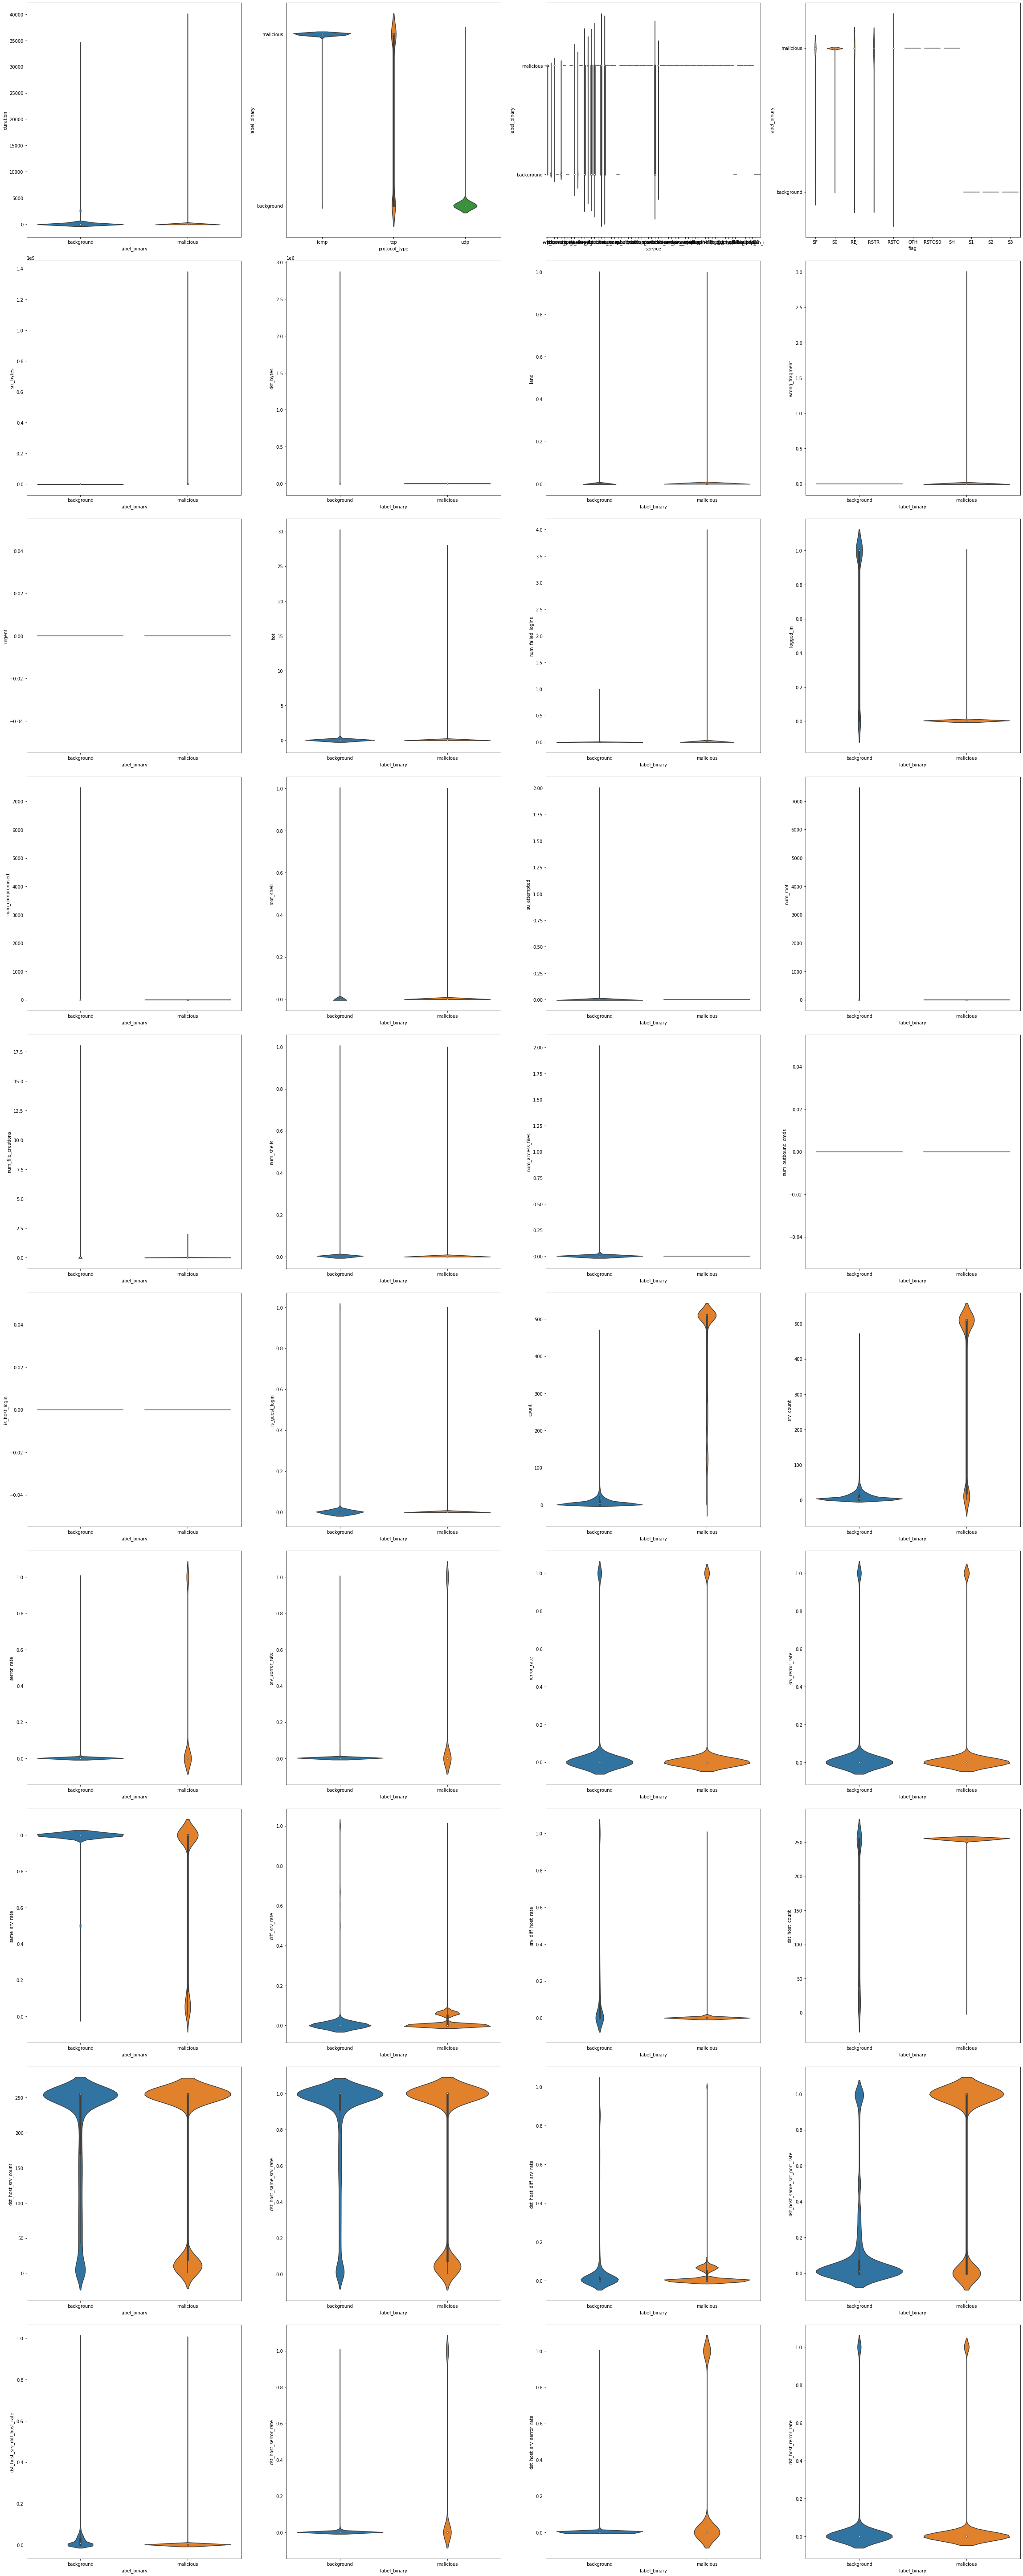

In [33]:
cols_to_plot = train.columns[:-3]
SIZE = len(cols_to_plot)
HEIGHT = SIZE//4 + 1*(SIZE%4!=0)
WIDTH = 4
fig, axes = plt.subplots(HEIGHT, WIDTH,figsize=(8*WIDTH, 8*HEIGHT))
data=train.sample(100_000)
axes = axes.ravel()
for i,j,k in zip(cols_to_plot, train[cols_to_plot].dtypes, range(len(cols_to_plot))):
    if j == "object":
        sns.violinplot(x=i, y="label_binary",data=data, ax=axes[k])
        axes[k].set_yticks([0,1])
        axes[k].set_yticklabels(["background", "malicious"])
    else:
        sns.violinplot(x="label_binary", y=i, data=data, ax=axes[k])
        axes[k].set_xticks([0,1])
        axes[k].set_xticklabels(["background", "malicious"])
[axes[x].set_visible(False) for x in range(k, WIDTH*HEIGHT)]
plt.tight_layout()

Taking a closer look at the `service` column:

([<matplotlib.axis.YTick at 0x2049be98488>,
 [Text(0, 0, 'background'), Text(0, 0, 'malicious')])

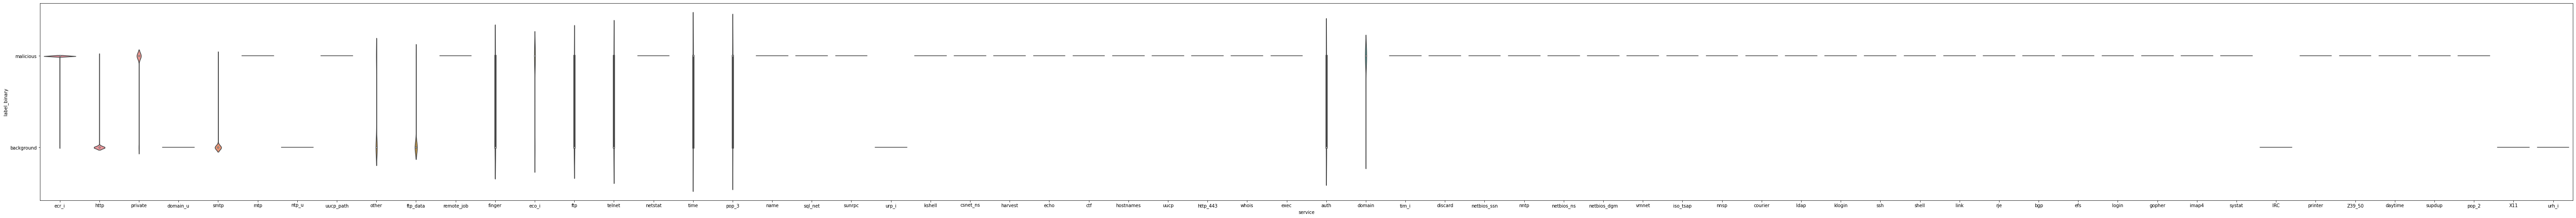

In [38]:
plt.figure(figsize=(100,8))
sns.violinplot(x="service", y="label_binary", data=data)
plt.yticks([0,1], ["background", "malicious"])

In [ ]:
train["service"].value_counts()